[View in Colaboratory](https://colab.research.google.com/github/Yahsama/yahsama/blob/master/MarginTest01.ipynb)

# 一度実行したら見なくてよいルーチン

必要なライブラリインポート

In [0]:
# 宣言
import time
import math
import datetime
from scipy.stats import norm  # 正規分布


ブラック・ショールズ関数の定義

In [0]:
# ブラックショールズ関数定義

# Clean Volatirity
def CleanV(Vol):
  if Vol > 0.01:
    return Vol
  else:
    return 0.1
    # return Vol

# 共通の中間関数 ?0 → ?
def BS_rqvt(r0, q0, v0, t0):
  r = math.log(r0 / 100 + 1)
  q = math.log(q0 / 100 + 1)
  V = CleanV(v0) / 100
  t = t0 / 365 
  return r, q, V, t
  
# 理論価格
def BS_Price(TP, S, K, r0, q0, v0, t0):
  r, q, V, t = BS_rqvt(r0, q0, v0, t0)
  d1 = (math.log(S / K) + (r - q + V * V / 2) * t) / V / math.sqrt(t)
  d2 = d1 - V * math.sqrt(t)
  
  if TP == "C":
    Price = S * math.exp(-q * t) * norm.cdf(x=d1, loc=0, scale=1) - math.exp(-r * t) * K * norm.cdf(x=d2, loc=0, scale=1)
  elif TP == "P":
    Price = -1 * S * math.exp(-q * t) * norm.cdf(x=-1*d1, loc=0, scale=1) + math.exp(-r * t) * K * norm.cdf(x=-1*d2, loc=0, scale=1)
  elif TP == "F":
    Price = S
  else:
    Price = 0    
  return Price

# プット・コールパリティ
def BS_PCParity(S, K, r0, q0, v0, t0):
  r, q, V, t = BS_rqvt(r0, q0, v0, t0)
    
  d1 = (math.log(S / K) + (r - q + V * V / 2) * t) / V / math.sqrt(t)
  d2 = d1 - V * math.sqrt(t)
  
  PCParity = BS_Price(TP, S, K, r0, q0, v0, t0) - S * math.exp(-q * t) * K * math.exp(-r * t)    
  return PCParity

# デルタ
def BS_Delta(TP, S, K, r0, q0, v0, t0):
  r, q, V, t = BS_rqvt(r0, q0, v0, t0)

  if not (TP == "F"):
    d1 = (math.log(S / K) + (r - q + V * V / 2) * t) / V / math.sqrt(t)
  
  if TP == "C":
    DeltaCP = math.exp(-q * t) * (norm.cdf(x=d1, loc=0, scale=1))
  elif TP == "P":
    DeltaCP = math.exp(-q * t) * (norm.cdf(x=d1, loc=0, scale=1) - 1)
  elif TP == "F":
    DeltaCP = 0.1
  else:
    DeltaCP = 0    
  return DeltaCP
    
# ガンマ
def BS_Gamma(TP, S, K, r0, q0, v0, t0):
  r, q, V, t = BS_rqvt(r0, q0, v0, t0)
    
  if TP == "C" or TP == "P":
    d1 = (math.log(S / K) + (r - q + V * V / 2) * t) / V / math.sqrt(t)  
    Gamma = math.exp(-q * t) * (norm.pdf(x=d1, loc=0, scale=1)) / S / V / math.sqrt(t)
  else:
    Gamma = 0   
  return Gamma
   
# ベガ
def BS_Kappa(TP, S, K, r0, q0, v0, t0):
  r, q, V, t = BS_rqvt(r0, q0, v0, t0)
    
  if TP == "C" or TP == "P":
    d1 = (math.log(S / K) + (r - q + V * V / 2) * t) / V / math.sqrt(t)
    Kappa = math.exp(-q * t) * (norm.pdf(x=d1, loc=0, scale=1)) * S * math.sqrt(t) / 100
  else:
    Kappa = 0    
  return Kappa
   
# セータ
def BS_Theta(TP, S, K, r0, q0, v0, t0):
  r, q, V, t = BS_rqvt(r0, q0, v0, t0)
    
  if TP == "C" or TP == "P":
    d1 = (math.log(S / K) + (r - q + V * V / 2) * t) / V / math.sqrt(t)
    d2 = d1 - V * math.sqrt(t)
  
  if TP == "C":
    Theta = ( S * math.exp(-q * t) * (-1 * norm.pdf(x=d1, loc=0, scale=1) * V / 2 / math.sqrt(t) + q * norm.cdf(x=d1, loc=0, scale=1)) - r * K * math.exp(-q * t) * norm.cdf(x=d2, loc=0, scale=1)) / 365
  elif TP == "P":
    Theta = ( -1 * S * math.exp(-q * t) * (norm.pdf(x=d1, loc=0, scale=1) * V / 2 / math.sqrt(t) + q * norm.cdf(x=-1*d1, loc=0, scale=1)) - r * K * math.exp(-q * t) * norm.cdf(x=-1*d2, loc=0, scale=1)) / 365
  else:
    Theta = 0   
  return Theta

# インプライド・ボラティリティ
def BS_IV(TP, V, S, K, r0, q0, t0):
  RateL = 0.5
  RateS = 0.05
  
  if TP == "C" or TP == "P":
    PriceL = BS_Price(TP, S, K, r0, q0, RateL, t0)
    PriceS = BS_Price(TP, S, K, r0, q0, RateS, t0)
  
    while PriceL <= V:
      RateL  = RateL * 2
      PriceL = BS_Price(TP, S, K, r0, q0, RateL, t0)
    while PriceS >= V:
      RateS  = RateS / 2
      PriceS = BS_Price(TP, S, K, r0, q0, RateS, t0)
    while RateL-RateS >= 0.00001:
      RateM = (RateL + RateS) / 2
      PriceM = BS_Price(TP, S, K, r0, q0, RateM, t0)
      if PriceM > V:
        RateL = RateM
      elif PriceM < V:
        RateS = RateM
      else:
        break
  elif TP == "F":
    RateM = -1     
  return RateM

パラメータ定義

In [0]:
################################################################　
#   SPANパラメータのうち、定期見直しがないもの
################################################################　
DELTA_WEIGHT = 1.0
DELTA_SCALING_FACTOR = 1.0
DELTA_SPREAD_RATIO = 1.0

# デルタ関連パラメータ
#                          1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16
DeltaWeight        = [ 0.135, 0.135,0.1085,0.1085,0.1085,0.1085,0.0555,0.0555,0.0555,0.0555,0.0185,0.0185,0.0185,0.0185, 0.000, 0.000]
SonScalingFactor   = [     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1, 0.300, 0.300]
DeltaScalingFactor = 1

# SPANシナリオ係数
#                    1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     
SpanPSR_Factor = [   0,     0,  0.33,  0.33, -0.33, -0.33,  0.67,  0.67, -0.67, -0.67,  1.00,  1.00, -1.00, -1.00,  3.00, -3.00 ]
SpanVSR_Factor = [   1,    -1,     1,    -1,     1,    -1,     1,    -1,     1,    -1,     1,    -1,     1,    -1,     0,     0 ]

################################################################　
#   SPANパラメータのうち、定期見直しされるもの
################################################################　
PSR = 720000
VSR = 6.64
NET_DELTA_SPREAD_PREMIUM = 40000
MINIMUM_SHORT = 44700


In [36]:
# ブラック・ショールズ関数の軽い検証
TYPE = "C"
N225 = 22305
STRIKE = 22750
IV = 12.93
RDAY = 13
PRICE = 64.6

print ('Price　is {0:.2f}'.format(BS_Price(TYPE, N225, STRIKE, 0, 0, IV, RDAY)))
print ("Delta　is {0:.2f}".format(BS_Delta(TYPE, N225, STRIKE, 0, 0, IV, RDAY)))
print ("Gamma　is {0:.4f}".format(BS_Gamma(TYPE, N225, STRIKE, 0, 0, IV, RDAY)))
print ("Kappa　is {0:.2f}".format(BS_Kappa(TYPE, N225, STRIKE, 0, 0, IV, RDAY)))
print ("Theta　is {0:.2f}".format(BS_Theta(TYPE, N225, STRIKE, 0, 0, IV, RDAY)))
print ("IV   　is {0:.2f}".format(BS_IV   (TYPE, PRICE, N225, STRIKE, 0, 0, RDAY)))

Price　is 64.97
Delta　is 0.21
Gamma　is 0.0005
Kappa　is 12.22
Theta　is -6.08
IV   　is 12.90


# 証拠金算出本体

保有ポジションのIV,グリークス計算

In [0]:
import datetime

# クラス
#   保有ポジションにIV、グリークスの現時点評価値を付加
class AppendIVGreeksToCurrentPositionList():
  # コンストラクタ
  def __init__( self, UnderlyingCurrentPrice, EvalDay, PositionList ):
    self.UnderlyingCurrentPrice = UnderlyingCurrentPrice
    self.EvalDay                = EvalDay
    
    self.Position               = PositionList
    self.TotalCurrentGreeks     = {}    
     
  # 現在の値(残存日数, プレミアムから逆算されるIV, グリークス)を算出
  def CalcCurrentPremiumGreeks( self ):
    for Pos in self.Position:
      # 辞書配列に格納
      Pos["DaysRemain"] = ( datetime.datetime.strptime(Pos["SQday"], "%Y/%m/%d") - datetime.datetime.strptime( self.EvalDay, "%Y/%m/%d") ).days
      Pos["IV"]         = BS_IV(Pos["CPF"], Pos["CurrentPrice"], self.UnderlyingCurrentPrice, Pos["Strike"], 0, 0, Pos["DaysRemain"])
      Pos["Delta"]      = BS_Delta(Pos["CPF"], self.UnderlyingCurrentPrice, Pos["Strike"], 0, 0, Pos["IV"], Pos["DaysRemain"]) * Pos["Count"]
      Pos["Gamma"]      = BS_Gamma(Pos["CPF"], self.UnderlyingCurrentPrice, Pos["Strike"], 0, 0, Pos["IV"], Pos["DaysRemain"]) * Pos["Count"]
      Pos["Theta"]      = BS_Theta(Pos["CPF"], self.UnderlyingCurrentPrice, Pos["Strike"], 0, 0, Pos["IV"], Pos["DaysRemain"]) * Pos["Count"]
      Pos["Vega"]       = BS_Kappa(Pos["CPF"], self.UnderlyingCurrentPrice, Pos["Strike"], 0, 0, Pos["IV"], Pos["DaysRemain"]) * Pos["Count"]        

  # 現在のグリークス合計
  def CalcCurrentTotalGreeks( self ):
    self.TotalCurrentGreeks["Delta"] = 0 ; self.TotalCurrentGreeks["Gamma"] = 0 ; self.TotalCurrentGreeks["Theta"] = 0 ; self.TotalCurrentGreeks["Vega"] = 0
    for num in range(len(self.Position)):
      self.TotalCurrentGreeks["Delta"]    += self.Position[num]["Delta"]
      self.TotalCurrentGreeks["Gamma"]    += self.Position[num]["Gamma"]
      self.TotalCurrentGreeks["Theta"]    += self.Position[num]["Theta"]
      self.TotalCurrentGreeks["Vega"]     += self.Position[num]["Vega"] 

損益シミュレーション、証拠金シミュレーション

In [0]:
# クラス
#   シミュレーション（損益、証拠金）
class CalcMarginProfit():  
  
  # コンストラクタ
  def __init__( self, UnderlyingCurrentPrice, EvalDay, UnderlyingOffset, IVoffset, SimDay, PositionList ):
    self.UnderlyingCurrentPrice = UnderlyingCurrentPrice
    self.UnderlyingAssmpPrice   = UnderlyingCurrentPrice + UnderlyingOffset
    self.IVoffset               = IVoffset
    self.EvalDay                = EvalDay
    self.SimDay                 = SimDay
    
    self.TotalSimValues = {}
    self.Position       = PositionList
    
  # シミュレーション値(OP価値、損益)算出
  def CalcSimPremium( self ):
    for Pos in self.Position:
      # まずはUnderlyingSimPrice, SimIV, DaysEvalを算出
      Pos["UnderlyingSimPrice"] = self.UnderlyingAssmpPrice
      if not (Pos["CPF"] == "F"):
        Pos["SimIV"]   = max( 0.001, Pos["IV"] + self.IVoffset )
      else:
        Pos["SimIV"]   = 0
      Pos["DaysSim"]   = ( datetime.datetime.strptime(Pos["SQday"], '%Y/%m/%d') - datetime.datetime.strptime( self.SimDay, "%Y/%m/%d") ).days
      
      if Pos["CPF"]=="C"or Pos["CPF"]=="P":
        Pos["SimPremium"] = BS_Price(Pos["CPF"], Pos["UnderlyingSimPrice"], Pos["Strike"], 0, 0, Pos["SimIV"], Pos["DaysSim"]) * Pos["Count"] * 1000
        Pos["SimProfLoss"]= Pos["SimPremium"] - ( Pos["CurrentPrice"] * Pos["Count"] *1000 )

      else:
        Pos["SimPremium"] = 0
        Pos["SimProfLoss"]= ( Pos["UnderlyingSimPrice"] -  Pos["CurrentPrice"]) * Pos["Count"] * 100
        
  # シミュレーション値(各グリークス)算出
  def CalcSimGreeks( self ):
    for Pos in self.Position:
      if Pos["CPF"]=="C"or Pos["CPF"]=="P":
        Pos["SimDelta"]   = BS_Delta(Pos["CPF"], Pos["UnderlyingSimPrice"], Pos["Strike"], 0, 0, Pos["SimIV"], Pos["DaysSim"]) * Pos["Count"]
        Pos["SimGamma"]   = BS_Gamma(Pos["CPF"], Pos["UnderlyingSimPrice"], Pos["Strike"], 0, 0, Pos["SimIV"], Pos["DaysSim"]) * Pos["Count"]
        Pos["SimTheta"]   = BS_Theta(Pos["CPF"], Pos["UnderlyingSimPrice"], Pos["Strike"], 0, 0, Pos["SimIV"], Pos["DaysSim"]) * Pos["Count"]
        Pos["SimVega"]    = BS_Kappa(Pos["CPF"], Pos["UnderlyingSimPrice"], Pos["Strike"], 0, 0, Pos["SimIV"], Pos["DaysSim"]) * Pos["Count"]
      else:
        Pos["SimDelta"]   = 0.1 *  Pos["Count"]
        Pos["SimGamma"]   = 0
        Pos["SimTheta"]   = 0
        Pos["SimVega"]    = 0  

  # 合計のシミュレーション値(OP価値、損益)算出
  def CalcSimTotalPremium( self ):
    self.TotalSimValues["UnderlyingSimPrice"] = self.UnderlyingAssmpPrice
    self.TotalSimValues["IVoffset"] = self.IVoffset
    
    self.TotalSimValues["SimPremium"]  = 0 ; self.TotalSimValues["SimProfLoss"] = 0
    for num in range(len(self.Position)):
      self.TotalSimValues["SimPremium"]  += self.Position[num]["SimPremium"]
      self.TotalSimValues["SimProfLoss"] += self.Position[num]["SimProfLoss"]
 
  # 合計のシミュレーション値(各グリークス)算出, 必ずCalcSimTotalPremiumの後に呼ぶこと
  def CalcSimTotalGreeks( self ):  
    self.TotalSimValues["SimDelta"] = 0 ; self.TotalSimValues["SimGamma"] = 0 ; self.TotalSimValues["SimTheta"] = 0 ; self.TotalSimValues["SimVega"] = 0
    for num in range(len(self.Position)):
      self.TotalSimValues["SimDelta"]    += self.Position[num]["SimDelta"]
      self.TotalSimValues["SimGamma"]    += self.Position[num]["SimGamma"]
      self.TotalSimValues["SimTheta"]    += self.Position[num]["SimTheta"]
      self.TotalSimValues["SimVega"]     += self.Position[num]["SimVega"]
 
  # リスクシナリオシミュレーション値
  def CalcMarginRiskScenarioSim( self ):
    for Pos in self.Position:
      ScenarioList = []
      CompositDelta = 0
      # シナリオ毎
      for ScenarioNum in range(16):
        ScenarioN225 = max(0, Pos["UnderlyingSimPrice"] + (PSR/1000) * SpanPSR_Factor[ScenarioNum])
        ScenarioIV  = max(0.01, Pos["SimIV"] + VSR * SpanVSR_Factor[ScenarioNum])
        if Pos["CPF"]=="C"or Pos["CPF"]=="P":
          premium       = BS_Price(Pos["CPF"], ScenarioN225, Pos["Strike"], 0, 0, ScenarioIV, Pos["DaysSim"])
          weighteddelta =  BS_Delta(Pos["CPF"], ScenarioN225, Pos["Strike"], 0, 0, ScenarioIV, Pos["DaysSim"]) * DeltaWeight[ScenarioNum] * Pos["Count"]
          profloss      = ( premium - Pos["CurrentPrice"] ) * SonScalingFactor[ScenarioNum] * Pos["Count"]
        elif Pos["CPF"]=="F":
          premium       = -1
          weighteddelta = 0.1 * DeltaWeight[ScenarioNum] * Pos["Count"]
          profloss      = ( ScenarioN225 - Pos["CurrentPrice"] ) * SonScalingFactor[ScenarioNum] * Pos["Count"] / 10
        ScenarioList.append( { "premium":premium, "profloss":profloss, "weighteddelta":weighteddelta } )
        # コンポジットデルタ ← リスクシナリオシミュレーションのついでに計算している
        CompositDelta += weighteddelta
        
      Pos["Scenario"]      = ScenarioList
      Pos["CompositDelta"] = CompositDelta
           
  # リスクシナリオごとの損益
  def CalcMarginScanRisk( self ):
    RiskList = []
    for ScenarioNum in range(16):
      ScenarioRisk = 0
      for Pos in self.Position:
        ScenarioRisk += Pos["Scenario"][ScenarioNum]["profloss"]
      RiskList.append(ScenarioRisk)
    self.TotalSimValues["RiskList"] = RiskList
    # マイナス最大値をスキャンリスク値
    ActiveValue = min(RiskList) 
    # スキャンリスク値からアクティブシナリオを逆引き
    self.TotalSimValues["RiskScenario"] = RiskList.index(ActiveValue)
    # ① スキャンリスク決定
    self.TotalSimValues["ScanRisk"] = ActiveValue * 1000

  # 限月間スプレッド割増額
  def CalcMarginSpread( self ):
    A_NetDelta = {}
    #  まず、保有ポジションの限月種類を列挙
    SQ_List = []
    for Pos in self.Position:
      if Pos["SQday"] not in SQ_List:
        SQ_List.append(Pos["SQday"])
       
    # 限月種類ごとに箱を用意
    for SQ in SQ_List:
      A_NetDelta[SQ] = { "Long":0, "Short":0 }
      
    # 保有ポジションを探索し、限月種類ごとデルタを加算  → ①
    for Pos in self.Position:
      if Pos["Count"] > 0:
        A_NetDelta[Pos["SQday"]]["Long"] += Pos["CompositDelta"]
      elif Pos["Count"] < 0:
        A_NetDelta[Pos["SQday"]]["Short"] += Pos["CompositDelta"]
    
    # 限月間スプレッド発生判定   → B,D
    #   異限月の組合せを列挙
    SQ_Comb = []
    for SQ1 in SQ_List:
      for SQ2 in SQ_List:
        if (SQ1 != SQ2) and (not((SQ2+SQ1) in SQ_Comb)) and (not((SQ1+SQ2) in SQ_Comb)):         
          # スプレッド有無判定  → D
          SQ1Net = A_NetDelta[SQ1]["Long"] + A_NetDelta[SQ1]["Short"]
          SQ2Net = A_NetDelta[SQ2]["Long"] + A_NetDelta[SQ2]["Short"]
          # 条件判定
          if ( SQ1Net != 0) and (SQ2Net != 0):
            SQ_Comb.append( SQ1+SQ2 )
            # 異限月組み合わせ毎に限月間スプレッド数算出 → E
            E_Spread = min( abs(SQ1Net), abs(SQ2Net) ) * DELTA_SPREAD_RATIO
            # 割増額 → F
            self.TotalSimValues["F_SpreadPremium"] = E_Spread * NET_DELTA_SPREAD_PREMIUM
          else:
            self.TotalSimValues["F_SpreadPremium"] = 0

  # 証拠金算出
  def CalcMarginFinal( self ):
    # ③ 中間式
    self.TotalSimValues["3_IntermediateValue"] = abs(self.TotalSimValues["ScanRisk"]) + self.TotalSimValues["F_SpreadPremium"]
    
    # ④ 売り枚数最低証拠金計算
    CountOpShort = 0
    for Pos in self.Position:
      if Pos["Count"] < 0:
        CountOpShort += Pos["Count"]   
        
    self.TotalSimValues["4_ShortMinimumValue"] = abs(CountOpShort) * MINIMUM_SHORT
    
    # ⑤ SPAN証拠金額  (③と④の大きい方) 
    self.TotalSimValues["5_SPANmargin"] = max( self.TotalSimValues["3_IntermediateValue"], self.TotalSimValues["4_ShortMinimumValue"] )

    # ⑥ ネット・オプション価値総額計算 ← 計算済み
    # 最終証拠金額
    self.TotalSimValues["FinalMargin"] = max( 0, self.TotalSimValues["5_SPANmargin"] - self.TotalSimValues["SimPremium"] )


# API開発


In [0]:
# API用関数
def AttachIVGreeks( PositionList, AssetValue, EvalDay ):
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, PositionList )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  return PositionList

In [0]:
# API用関数
def CalcTotalGreeks( PositionList, AssetValue, EvalDay ):
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, PositionList )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  CalcTotalGreeks = { 
                    "Delta":ap.TotalCurrentGreeks["Delta"], "Gamma":ap.TotalCurrentGreeks["Gamma"], "Theta":ap.TotalCurrentGreeks["Theta"], "Vega":ap.TotalCurrentGreeks["Vega"]
                    }
  
  return CalcTotalGreeks

In [0]:
# API用関数
def AttachSimProfitGreeks( PositionList, AssetValue, EvalDay, AssetOffset, IVOffset, SimDay ):
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, PositionList )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  # ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  # インスタンスを生成するためのマトリクスループ
  cm = CalcMarginProfit( AssetValue, EvalDay, AssetOffset, IVOffset, SimDay, PositionList )
 
  # 実行         
  cm.CalcSimPremium()              # ポジション毎のプレミアム、損益 総和
  cm.CalcSimGreeks()               # ポジション毎のグリークス 総和
  cm.CalcSimTotalPremium()         # ポジショントータルのリスクシナリオ毎の値(プレミアム, 損益)を計算
  cm.CalcSimTotalGreeks()          # ポジショントータルのリスクシナリオ毎の値(グリークス)を計算
 
  return PositionList

In [0]:
# API用関数
def CalcSimTotalProfitGreeks( PositionList, AssetValue, EvalDay, AssetOffset, IVOffset, SimDay ):
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, PositionList )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  # ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  # インスタンスを生成するためのマトリクスループ
  cm = CalcMarginProfit( AssetValue, EvalDay, AssetOffset, IVOffset, SimDay, PositionList )
 
  # 実行         
  cm.CalcSimPremium()              # ポジション毎のプレミアム、損益 総和
  cm.CalcSimGreeks()               # ポジション毎のグリークス 総和
  cm.CalcSimTotalPremium()         # ポジショントータルのリスクシナリオ毎の値(プレミアム, 損益)を計算
  cm.CalcSimTotalGreeks()          # ポジショントータルのリスクシナリオ毎の値(グリークス)を計算
  # cm.CalcMarginRiskScenarioSim()   # ポジションごとのリスクシミュレーション結果(プレミアム、コンポジットデルタ、損益)を計算
  # cm.CalcMarginScanRisk()          # ポジショントータルのリスクシミュレーション値を計算 → ①
  # cm.CalcMarginSpread()            # ② 限月間スプレッド計算   
  # cm.CalcMarginFinal()             # 証拠金計算      

  CalcSimTotalProfitGreeks = { "Premium":cm.TotalSimValues["SimPremium"], "ProfLoss":cm.TotalSimValues["SimProfLoss"],
                                "Delta":cm.TotalSimValues["SimDelta"], "Gamma":cm.TotalSimValues["SimGamma"], 
                                "Theta":cm.TotalSimValues["SimTheta"], "Vega":cm.TotalSimValues["SimVega"]
                    }
  
  return CalcSimTotalProfitGreeks

In [0]:
# API用関数
def CalcMargin( PositionList, AssetValue, EvalDay, AssetOffset, IVOffset, SimDay ):
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, PositionList )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  # ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  # インスタンスを生成するためのマトリクスループ
  cm = CalcMarginProfit( AssetValue, EvalDay, AssetOffset, IVOffset, SimDay, PositionList )
 
  # 実行         
  cm.CalcSimPremium()              # ポジション毎のプレミアム、損益 総和
  # cm.CalcSimGreeks()               # ポジション毎のグリークス 総和
  cm.CalcSimTotalPremium()         # ポジショントータルのリスクシナリオ毎の値(プレミアム, 損益)を計算
  # cm.CalcSimTotalGreeks()          # ポジショントータルのリスクシナリオ毎の値(グリークス)を計算
  cm.CalcMarginRiskScenarioSim()   # ポジションごとのリスクシミュレーション結果(プレミアム、コンポジットデルタ、損益)を計算
  cm.CalcMarginScanRisk()          # ポジショントータルのリスクシミュレーション値を計算 → ①
  cm.CalcMarginSpread()            # ② 限月間スプレッド計算   
  cm.CalcMarginFinal()             # 証拠金計算      

  Margin = cm.TotalSimValues["FinalMargin"]
  
  return Margin

In [0]:
# API用関数
def CalcMarginPlus( PositionList, AssetValue, EvalDay, AssetOffset, IVOffset, SimDay ):
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, PositionList )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  # ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  # インスタンスを生成するためのマトリクスループ
  cm = CalcMarginProfit( AssetValue, EvalDay, AssetOffset, IVOffset, SimDay, PositionList )
 
  # 実行         
  cm.CalcSimPremium()              # ポジション毎のプレミアム、損益 総和
  # cm.CalcSimGreeks()               # ポジション毎のグリークス 総和
  cm.CalcSimTotalPremium()         # ポジショントータルのリスクシナリオ毎の値(プレミアム, 損益)を計算
  # cm.CalcSimTotalGreeks()          # ポジショントータルのリスクシナリオ毎の値(グリークス)を計算
  cm.CalcMarginRiskScenarioSim()   # ポジションごとのリスクシミュレーション結果(プレミアム、コンポジットデルタ、損益)を計算
  cm.CalcMarginScanRisk()          # ポジショントータルのリスクシミュレーション値を計算 → ①
  cm.CalcMarginSpread()            # ② 限月間スプレッド計算   
  cm.CalcMarginFinal()             # 証拠金計算      

  MarginPlus = { "ScanRisk":cm.TotalSimValues["ScanRisk"], "RiskScenario":cm.TotalSimValues["RiskScenario"], 
                 "F_SpreadPremium":cm.TotalSimValues["F_SpreadPremium"], "3_IntermediateValue":cm.TotalSimValues["3_IntermediateValue"], 
                 "4_ShortMinimumValue":cm.TotalSimValues["4_ShortMinimumValue"], "5_SPANmargin":cm.TotalSimValues["5_SPANmargin"],
                 "FinalMargin":cm.TotalSimValues["FinalMargin"]  }
  
  return MarginPlus

# マトリクスループ＆グラフ

シミュレーション・マトリクス

In [0]:
################################################################　
# シミュレーション・マトリクス・ループ
################################################################　
def MatrixLoop( AssetValue, AssetRange, AssetStep, IVRange, IVStep, EvalDay, SimDay, Position ):

  SimIVStart    = -1 * IVRange    * IVStep
  SimIVEnd      =      IVRange    * IVStep
  SimAssetStart = -1 * AssetRange * AssetStep
  SimAssetEnd   =      AssetRange * AssetStep
 
  # 現在のポジションにIV,グリークス情報を付加
  ap = AppendIVGreeksToCurrentPositionList( AssetValue, EvalDay, Position )
  ap.CalcCurrentPremiumGreeks()    # 現時点の全ポジションのIV、残存日数、グリークスを計算
  ap.CalcCurrentTotalGreeks()      # 現時点の合計グリークス計算
  
  # インスタンスを生成するためのマトリクスループ
  cmV = []
  for SimIVOffset in range( SimIVStart, SimIVEnd+1, IVStep ):
    cmH = []
    for SimAssetOffset in range( SimAssetStart, SimAssetEnd+1, AssetStep ):
      # インスタンス生成
      cmH.append( CalcMarginProfit( AssetValue, EvalDay, SimAssetOffset, SimIVOffset, SimDay, Position ) )
 
    cmV.append(cmH)

  # 証拠金計算メソッドを逐次呼出し
  for SimIVIndex in range( len(cmV) ):
    for SimAssetIndex in range( len(cmV[0]) ):
      # 実行         
      cmV[SimIVIndex][SimAssetIndex].CalcSimPremium()              # ポジション毎のプレミアム、損益 総和
      cmV[SimIVIndex][SimAssetIndex].CalcSimGreeks()               # ポジション毎のグリークス 総和
      cmV[SimIVIndex][SimAssetIndex].CalcSimTotalPremium()         # ポジショントータルのリスクシナリオ毎の値(プレミアム, 損益)を計算
      cmV[SimIVIndex][SimAssetIndex].CalcSimTotalGreeks()          # ポジショントータルのリスクシナリオ毎の値(グリークス)を計算
      cmV[SimIVIndex][SimAssetIndex].CalcMarginRiskScenarioSim()   # ポジションごとのリスクシミュレーション結果(プレミアム、コンポジットデルタ、損益)を計算
      cmV[SimIVIndex][SimAssetIndex].CalcMarginScanRisk()          # ポジショントータルのリスクシミュレーション値を計算 → ①
      cmV[SimIVIndex][SimAssetIndex].CalcMarginSpread()            # ② 限月間スプレッド計算   
      cmV[SimIVIndex][SimAssetIndex].CalcMarginFinal()             # 証拠金計算      

  return (cmV)
 

グラフ作成関数

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as FormatStrFormatter

# グラフ作成関数
def MakeGraph(cm):
  
  # Margin格納用の二次元リスト作成
  cmV = []
  profV = []
  IVList = []
  MarginMax = 0
  for iv in range( len(cm) ):
    cmH = []
    profH = []
    AssetList = []
    for asset in range( len(cm[0]) ):
      Margin = cm[iv][asset].TotalSimValues["FinalMargin"]
      cmH.append( Margin )
      profH.append( cm[iv][asset].TotalSimValues["SimProfLoss"] )
      MarginMax = max( MarginMax, Margin )
      AssetList.append( cm[iv][asset].TotalSimValues["UnderlyingSimPrice"] )
      # print ( " {:10,.0f} ".format(Margin, end='')      
      # plt.plot(cmH, marker="o")
    cmV.append(cmH)
    profV.append(profH)
    IVList.append( cm[iv][asset].TotalSimValues["IVoffset"] )
    # print ("")
    
  # PandasのDataFrame(二次元配列)に格納
  pdata = pd.DataFrame( cmV, columns=AssetList, index=IVList )
  pprof = pd.DataFrame( profV, columns=AssetList, index=IVList )
  # インデックス(IV)にてソート ← テーブル表示ではIV降順に表示させたいので
  pdata = pdata.sort_index(ascending=False)
  pprof = pprof.sort_index(ascending=False)
  
  #
  # テーブル作成
  #
  # 表中数値のカンマ表記

  # 表の色分け
  #pdata.iloc[2,1] = np.nan
  # pdata.style.highlight_null()

  # 表の表示
  pd.options.display.float_format = '{:,.0f}'.format
  display(pdata)
  
  #  display(Position)
  pd.options.display.float_format = '{:9,.0f}'.format
  display(pprof)
  
  #
  # グラフ作成
  #
  # グラフのスタイル指定
  # sns.set_style("dark")
  sns.set_style("white")
  
  # 中心値計算 (横方向)
  CenterMargin = cm[int((len(cm)-1)/2)][int((len(cm[0]))/2)].TotalSimValues["FinalMargin"]
  MinAsset     = cm[0][0].TotalSimValues["UnderlyingSimPrice"]
  MaxAsset     = cm[0][len(cm[0])-1].TotalSimValues["UnderlyingSimPrice"]  
  plt.hlines([CenterMargin], MinAsset, MaxAsset, linestyles="--", linewidth=0.3)

  # 中心値計算 (縦方向)
  CenterAsset = cm[int((len(cm)-1)/2)][int((len(cm[0]))/2)].TotalSimValues["UnderlyingSimPrice"]
  MaxMargin   = cm[int((len(cm)-1)/2)][int((len(cm[0]))/2)].TotalSimValues["UnderlyingSimPrice"]
  plt.vlines([CenterAsset], 0, MarginMax, linestyles="--", linewidth=0.3)
  
  # データ読み込み(行列反転)
  plt.plot(pdata.T, marker="o", markevery=int((len(cmH)-1)/4))
  
  # 各種ラベル
  plt.title("Margin simulation graph")
  plt.xlabel("Asset")
  plt.ylabel("Margin")
  
  plt.annotate('center', xy=(CenterAsset, CenterMargin), arrowprops=dict(width=30))
  
  # 縦軸(証拠金額)のカンマ区切り表記
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter.StrMethodFormatter('{x:,.0f}'))
 
  plt.legend()

  # グラフ上部と左部の枠線を消す
  sns.despine()
  
  # グラフ表示  
  plt.show()


# 検証

メイン

[{'CPF': 'C', 'SQday': '2018/07/13', 'Strike': 22750, 'Count': -1, 'PurchasePrice': 65, 'CurrentPrice': 65, 'DaysRemain': 13, 'IV': 12.932460045814514, 'Delta': -0.21267296843918448, 'Gamma': -0.0005333409383656294, 'Theta': 6.079233243972126, 'Vega': -12.221964249905428}, {'CPF': 'C', 'SQday': '2018/07/13', 'Strike': 22500, 'Count': 0, 'PurchasePrice': 155, 'CurrentPrice': 155, 'DaysRemain': 13, 'IV': 14.229754376411437, 'Delta': 0.0, 'Gamma': 0.0, 'Theta': -0.0, 'Vega': 0.0}, {'CPF': 'F', 'SQday': '2018/07/13', 'Strike': None, 'Count': 0, 'PurchasePrice': 22305, 'CurrentPrice': 22305, 'DaysRemain': 13, 'IV': -1, 'Delta': 0.0, 'Gamma': 0, 'Theta': 0, 'Vega': 0}, {'CPF': 'C', 'SQday': '2018/08/10', 'Strike': 22750, 'Count': 0, 'PurchasePrice': 230, 'CurrentPrice': 230, 'DaysRemain': 41, 'IV': 13.782989001274109, 'Delta': 0.0, 'Gamma': 0.0, 'Theta': -0.0, 'Vega': 0.0}, {'CPF': 'P', 'SQday': '2018/07/13', 'Strike': 21750, 'Count': -1, 'PurchasePrice': 145, 'CurrentPrice': 145, 'DaysRemai

,21305,21405,21505,21605,21705,21805,21905,22005,22105,22205,...,22405,22505,22605,22705,22805,22905,23005,23105,23205,23305
20,"1,990,880","1,869,653","1,756,274","1,651,184","1,554,807","1,467,546","1,389,777","1,321,848","1,264,065","1,216,695",...,"1,269,216","1,326,300","1,393,629","1,470,931","1,557,892","1,654,157","1,759,339","1,873,018","1,994,753","2,124,083"
10,"1,731,333","1,589,796","1,455,986","1,330,552","1,214,152","1,107,451","1,011,109","925,769","852,045","790,508",...,"821,573","888,023","967,284","1,058,933","1,162,447","1,277,215","1,402,543","1,537,678","1,681,818","1,834,137"
0,"1,544,225","1,383,744","1,230,859","1,086,271","950,647","824,638","748,358","683,874","626,860","577,949",...,"599,736","639,456","690,166","752,197","840,893","981,766","1,135,535","1,300,440","1,474,597","1,656,146"
-10,"1,423,827","1,240,644","1,065,839","901,555","769,062","689,936","621,406","562,633","512,229","468,516",...,"487,560","514,780","546,054","593,066","674,693","823,189","1,020,447","1,220,123","1,420,050","1,620,022"
-20,"1,400,000","1,200,001","1,000,005","800,035","647,675","571,269","538,506","508,500","478,500","448,500",...,"481,500","511,500","541,500","571,500","656,500","820,003","1,020,000","1,220,000","1,420,000","1,620,000"


,21305,21405,21505,21605,21705,21805,21905,22005,22105,22205,...,22405,22505,22605,22705,22805,22905,23005,23105,23205,23305
20,"-613,350","-562,939","-517,288","-476,633","-441,193","-411,170","-386,742","-368,063","-355,259","-348,423",...,"-352,859","-364,145","-381,426","-404,617","-433,601","-468,227","-508,312","-553,649","-604,005","-659,127"
10,"-458,714","-397,525","-341,269","-290,324","-245,071","-205,888","-173,141","-147,179","-128,320","-116,841",...,"-116,850","-128,577","-148,146","-175,468","-210,365","-252,575","-301,756","-357,496","-419,330","-486,749"
0,"-341,094","-269,894","-203,964","-143,673","-89,345","-41,281",206,"34,738","61,832","80,871",...,"91,768","82,047","61,336","29,304","-13,996","-68,084","-132,075","-204,769","-284,774","-370,648"
-10,"-254,682","-168,933","-90,278","-20,393","39,438","88,564","127,094","155,867","176,271","189,984",...,"203,940","206,720","205,446","188,434","136,807","52,374","-45,208","-145,022","-245,006","-345,002"
-20,"-235,000","-135,000","-35,000","64,988","160,825","207,231","209,994","210,000","210,000","210,000",...,"210,000","210,000","210,000","210,000","155,000","55,000","-45,000","-145,000","-245,000","-345,000"


No handles with labels found to put in legend.


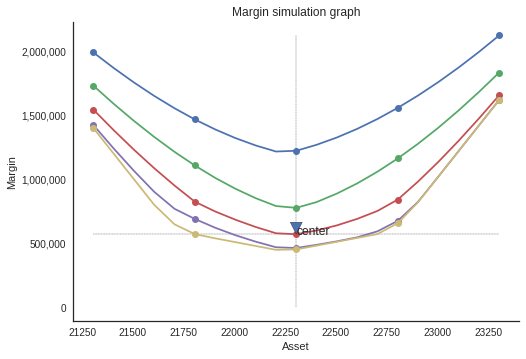

elapsed_time:  2.65[sec]


In [47]:

def main(): 
  ################################################################　
  #   シミュレーション時の市場情報
  ################################################################　
  N225          = 22305
  BaseDay       = '2018/06/30'
  BaseDayOffset = 5
  
  ################################################################　
  #   保有ポジションリスト
  ################################################################　
  PositionList = [
      #        CPF,                  SQ日,   権利行使価格,         枚数                    建値                  現在値
      {  "CPF":"C",  "SQday":"2018/07/13", "Strike":22750, "Count":  -1, "PurchasePrice":    65, "CurrentPrice":     65 },
      {  "CPF":"C",  "SQday":"2018/07/13", "Strike":22500, "Count":   0, "PurchasePrice":   155, "CurrentPrice":    155 },
      {  "CPF":"F",  "SQday":"2018/07/13", "Strike": None, "Count":   0, "PurchasePrice": 22305, "CurrentPrice":  22305 },
      {  "CPF":"C",  "SQday":"2018/08/10", "Strike":22750, "Count":   0, "PurchasePrice":   230, "CurrentPrice":    230 },
      {  "CPF":"P",  "SQday":"2018/07/13", "Strike":21750, "Count":  -1, "PurchasePrice":   145, "CurrentPrice":    145 },  ]
  
  
  # 評価日とSim日を計算(str形式)
  EvalDay   = BaseDay
  SimDay    = (datetime.datetime.strptime(BaseDay, '%Y/%m/%d') + datetime.timedelta(days=BaseDayOffset)).strftime('%Y/%m/%d')
  
  # API検証
  print ( AttachIVGreeks          ( PositionList, N225, EvalDay ) )
  print ( CalcTotalGreeks         ( PositionList, N225, EvalDay ) )
  print ( AttachSimProfitGreeks   ( PositionList, N225, EvalDay, -500, -0, SimDay ) )
  print ( CalcSimTotalProfitGreeks( PositionList, N225, EvalDay, -500, -0, SimDay ) )
  print ( CalcMargin              ( PositionList, N225, EvalDay, -500, -0, SimDay ) )
  print ( CalcMarginPlus          ( PositionList, N225, EvalDay, -500, -0, SimDay ) )
  
  cm = []  
  #                X中間値  X刻み数    X幅  Y刻み数    Y幅    評価日   Sim日 ポジションリスト
  cm = MatrixLoop(    N225,     10,    100,       2,    10,  EvalDay, SimDay,        PositionList )

  # グラフ表示関数
  MakeGraph (cm)
 
if __name__ == "__main__":
  start = time.time()
  main()
  elapsed = time.time() - start
  print ("elapsed_time:{0:6.2f}".format(elapsed) + "[sec]")
